DEBUG:root:data_generating.Run_data_generating started main
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
DEBUG:root:data_generating.Run_data_generating finished main
DEBUG:root:model_training.Run_model_training started main
ERROR:root:Model training process failed with the following error message:
ERROR:root:[Errno 2] No such file or directory: 'data/Dec-12-2020/snippets'

Number train examples: 212
Number test examples: 0


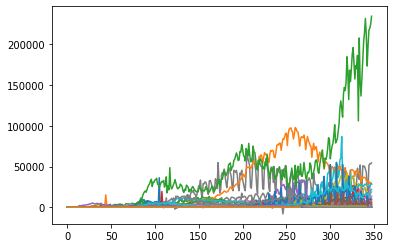

Number zero entries: 19188 Proportion: 0.3127475429074373
Total number entries: 61353
mean: 1146.345166495526
varianz: 44853161.96660977
quantiles (10%, 20% ...): [0.0, 0.0, 0.0, 4.0, 15.0, 50.0, 153.0, 464.0, 1479.0, 234633.0]
four quantiles: [0.0, 15.0, 271.0, 234633.0]
Number of negative values: 17
Negative values: [-209, -2461, -1480, -50, -8261, -766, -148, -6, -110, -105, -1385, -161, -9, -713, -372, -115, -1]


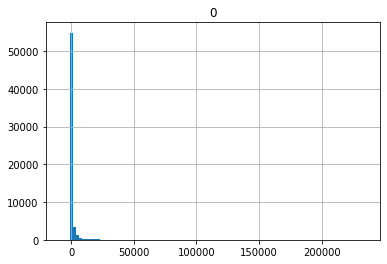

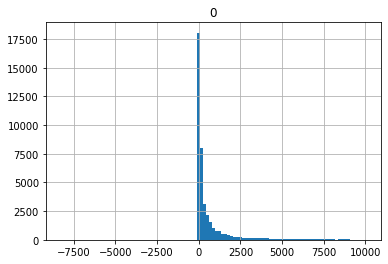

In [1]:
import data_generation_visual

In [5]:
import os
PROJECT_PATH = os.getcwd().replace("notebooks", "")
DATA_GEN_FOLDER_NAME = "Dec-12-2020"
EXAMPLES_DATASET_PATH = PROJECT_PATH + "data/" + DATA_GEN_FOLDER_NAME + "/total_snippets"
examples = data_generation_visual.load_Examples_from_file(EXAMPLES_DATASET_PATH)

In [6]:
test_example = examples.train_data[0]
print(f"Time Series shortened: \n{test_example.time_series[:100]},\n\
Time Series size: {test_example.time_series.shape[0]},\n\
Country: {test_example.country},\n\
Continent: {test_example.continent}")

Time Series shortened: 
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  3  3  3  6  5  1  0  0  2
  0 10  6  2 33  0 16 15  8 27 25 26 43  0 35 29 38 30 56 61 37 34 52 58
 49 70 10 51],
Time Series size: 338,
Country: Afghanistan,
Continent: Asia


In [7]:
import numpy as np
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans

X, y = [], []

for ex in examples.train_data:
    X.append(ex.time_series)

# to numpy array
X = to_time_series_dataset(X)

model = TimeSeriesKMeans(n_clusters=5, metric="dtw",
                         max_iter=10, random_state=42)
model.fit(X)

C:\Users\Lisa P-Punkt\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=10,
                 max_iter_barycenter=100, metric='dtw', metric_params=None,
                 n_clusters=5, n_init=1, n_jobs=None, random_state=42,
                 tol=1e-06, verbose=0)

In [8]:
import matplotlib.pyplot as plt

model.cluster_centers_.shape

(5, 348, 1)

### Computing of Distance Matrix DTW

In [15]:
from tslearn.metrics import dtw
from sklearn.metrics import pairwise_distances

no_countries = len(X)

X = []
for ex in examples.train_data:
    X.append(ex.time_series)

dtw_matrix = np.zeros(shape=(no_countries,no_countries))

for i in range(no_countries):
    for j in range(i,no_countries):
        if i==j:
            distance = 0
        else:
            distance = dtw(X[i], X[j])
        dtw_matrix[i,j] = distance
        dtw_matrix[j,i] = distance

dtw_matrix = pairwise_distances(X=dtw_matrix, metric='precomputed', n_jobs=-1)

### Computing of Distance Matrix Euklidian

#### TODO: TS different length

In [16]:
# from sklearn.metrics.pairwise import paired_euclidean_distances

# eucl_matrix = np.zeros(shape=(no_countries,no_countries))

# for i in X:
#     print(len(i))

# for i in range(no_countries):
#     for j in range(i,no_countries):
#         if i==j:
#             distance = 0
#         else:
#             distance = paired_euclidean_distances([X[i]], [X[j]])
#         eucl_matrix[i,j] = distance
#         eucl_matrix[j,i] = distance

# eucl_matrix = pairwise_distances(X=eucl_matrix, metric='precomputed')   

# Clustering

In [17]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering

### DBSCAN

In [45]:
db = DBSCAN(eps=5, metric='precomputed').fit(dtw_matrix)
# print(f"Epsilon: {eps}, no clusters: {dbscan.core_sample_indices_.shape[0]}")

In [46]:
core_samples = db.core_sample_indices_
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print(len(core_samples))

7


### AgglomerativeClustering

In [14]:
print("DTW")
for c in [5, 7, 13, 20, 31]:
    agg = AgglomerativeClustering(n_clusters=c, affinity='precomputed', linkage="average").fit(dtw_matrix)
    print(f"No Clusters: {c}, labels")

DTW
No Clusters: 5, labels
No Clusters: 7, labels
No Clusters: 13, labels
No Clusters: 20, labels
No Clusters: 31, labels


### K-Medoids

In [16]:
from sklearn_extra.cluster import KMedoids

kmedoids = KMedoids(n_clusters=13, metric='precomputed', random_state=0).fit(dtw_matrix)
kmedoids.labels_

array([ 7,  9,  9,  8,  8,  5,  5,  0,  1,  5,  7,  0,  6,  8,  4,  6,  5,
        3,  0,  2,  5,  5,  5,  4,  5,  3, 12, 10,  5,  5,  6,  5,  5,  5,
        4,  6,  8,  5,  5,  5,  0,  1,  0,  5,  8,  3,  7,  6,  8,  8,  8,
        0,  8,  3,  8,  5,  9,  1,  4,  4, 12,  5,  9,  5,  9,  5,  5,  5,
        9, 10,  4,  8,  5,  6, 10,  4,  5,  3,  5,  5,  8,  9,  5,  8,  5,
        5,  8,  5,  9,  6,  5, 10,  6,  0,  6,  9,  5,  0, 10,  8,  3,  5,
        0,  1,  9,  9,  9,  1,  5,  9,  3,  5,  5,  9,  5,  3,  9,  7,  5,
        3,  8,  8,  8,  5,  2,  5,  0,  3,  5,  5,  9,  5,  6,  8,  3,  8,
        1,  0,  5,  5,  7,  5, 11,  9,  5,  4,  4,  1,  3,  3,  5,  9,  0,
        1, 10,  0,  3,  4,  0, 10,  8,  5,  5,  5,  5,  5,  1,  8,  6,  5,
        5,  7,  5,  3,  3,  5,  5,  0, 11,  5, 10,  9,  7,  5,  0,  0,  8,
        5,  8,  5,  5,  5,  8,  1, 10,  5,  9,  0,  3, 10,  5,  5, 10,  8,
        7,  5,  4,  5,  5,  5,  7,  8], dtype=int64)

In [18]:
clusters = examples.divide_by_label(n_cluster=13, labels=kmedoids.labels_)

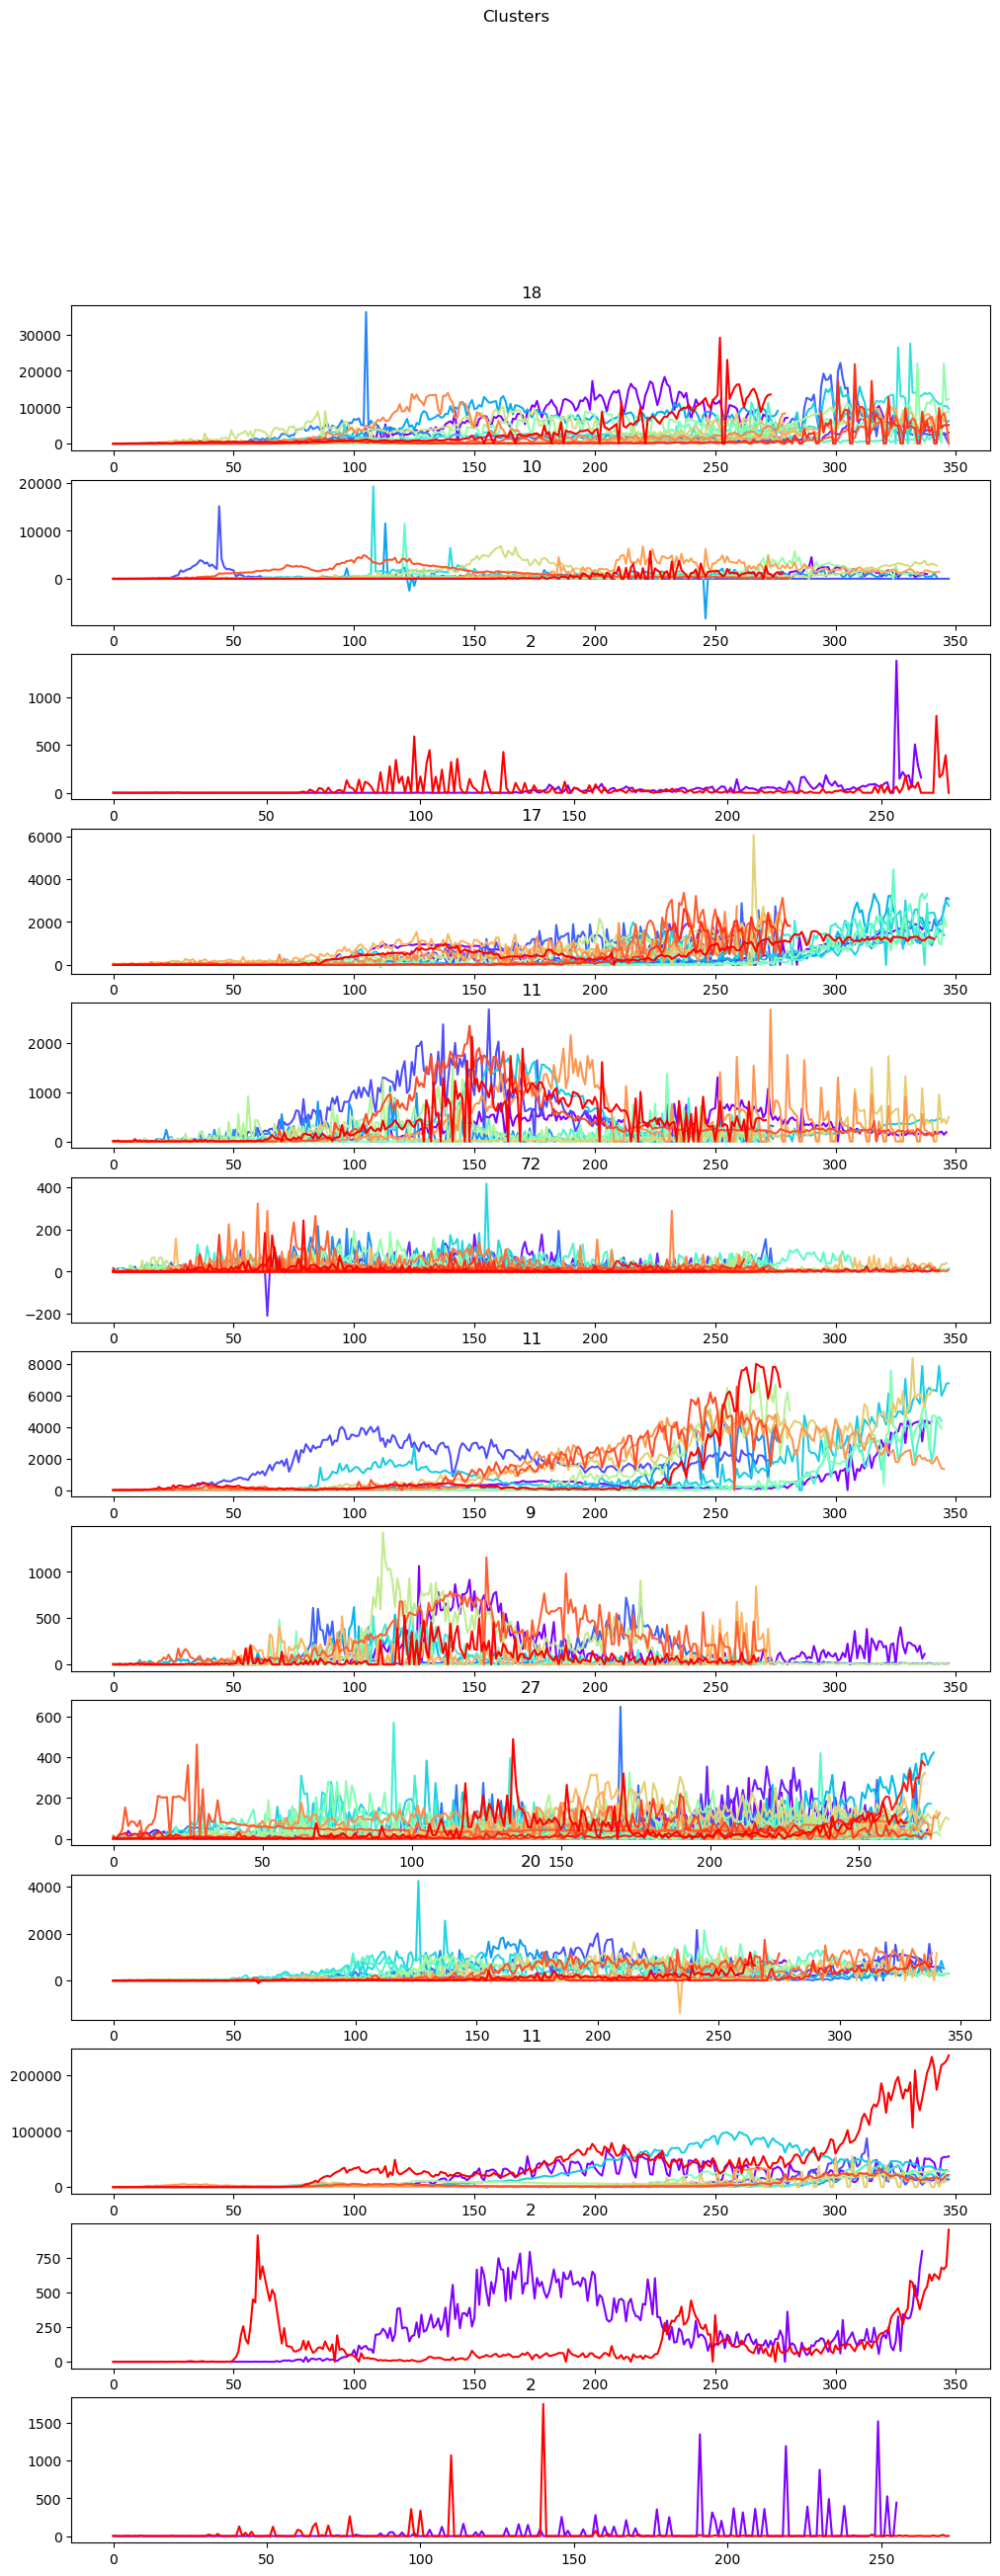

In [32]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

n = 13
fig, axs = plt.subplots(n, figsize=(12,30))
fig.suptitle('Clusters')

for i, cl in enumerate(clusters):
    color=iter(cm.rainbow(np.linspace(0,1,len(cl.train_data))))
    for ts in cl.train_data:
        cl_color = next(color)
        axs[i].plot(ts.time_series, c=cl_color)
        axs[i].set_title(str(len(cl.train_data)))

plt.show()